In [1]:
from bs4 import BeautifulSoup as soup
import matplotlib.pyplot as plt
from fa2 import ForceAtlas2
import community
import requests
import pandas as pd
import pickle
import time
import numpy as np
import re
import os

In [2]:
all_courses_raw = open('DTU Course Base.html', 'rb')
all_courses_soup = soup(all_courses_raw).find_all("a")
all_courses_tags = [course for course in all_courses_soup if re.search(r'https:\/\/kurser.dtu.dk\/course\/\d{5}', str(course))]
all_course_numbers = [course_tag.get_text()[:5] for course_tag in all_courses_tags]

In [3]:
def download_course(cnumber, key):
    r = requests.get(f'https://kurser.dtu.dk/course/{cnumber}', cookies = {'ASP.NET_SessionId': key})
    sp = soup(r.text)
    content = sp.find_all('tr')
    with open(f'courses/{cnumber}.p', 'wb') as file:
        pickle.dump(content, file)
    if os.path.getsize(f'courses/{cnumber}.p') <= 113:
        print(number)
        time.sleep(.5)
        download_course(cnumber, key)

In [4]:
key = 'um21ppjgafnbajty3smwkbkq'
"""
for i, cnumber in enumerate(all_course_numbers):
    download_course(cnumber, key)
    if i % 100 == 0:
        print(i, end=' ')
"""

"\nfor i, cnumber in enumerate(all_course_numbers):\n    download_course(cnumber, key)\n    if i % 100 == 0:\n        print(i, end=' ')\n"

In [5]:
def prerequisites(cnumber):
    prereqs_raw = [tr for tr in pickle.load(open(f'courses/{cnumber}.p','rb')) 
                    if 'prerequisites' in str(tr).lower()]
    try:
        prereqs_html = prereqs_raw[0]
    except:
        return ['None']
    prereq_cnums = []
    for prereqs_html in prereqs_raw:
        prereq_cnums += re.findall(r'\d{5}', str(prereqs_html))
    prereq_cnums = list(set(prereq_cnums))
    return prereq_cnums

def ects(cnumber):
    try:
        ects_raw = [tr for tr in pickle.load(open(f'courses/{cnumber}.p','rb')) 
                if ' ects ' in str(tr).lower()][0]
    except:
        return 1E10
    ects_text = ects_raw.get_text()
    ects = ects_text.replace('Point( ECTS )','').replace(',','.')
    return float(ects)

def capacity(cnumber):
    try:
        unique_prereqs = re.findall(r'(\d{5}\/?){1,}', 
                    [tr for tr in pickle.load(open(f'courses/{cnumber}.p','rb')) 
                        if 'prerequisites' in str(tr).lower()][0].get_text())
    except:
        return 0
    ects_points = 0
    for prereq in unique_prereqs:
        prereq = prereq.replace('/', '')
        try:
            ects_points += ects(prereq)
        except:
            ects_points += 5
    return ects_points

def course_name(cnumber, G = None):
    if cnumber == 'None':
        return "No prerequisites"
    if G != None:
        return G.nodes[cnumber]['name']
    try:
        tag_text = next(t for t in all_courses_tags 
         if cnumber in t.get_text()).get_text()
    except:
        return "No name found"
    course_name = tag_text[8:]
    return course_name

def create_edges():
    edges = []
    for cnumber in all_course_numbers:
        prereqs = prerequisites(cnumber)
        for prereq in prereqs:
            if prereq == cnumber or (cnumber, prereq) in edges:
                continue
            edges.append((prereq, cnumber))
    return edges

def sort_dict(d, course_nums = True, G = None):
    s = sorted(dict(d).items(), key = lambda x: x[1], reverse = True)
    if course_nums:
        return s
    else:
        return list(map(lambda x: course_name(x[0], G), s))

In [6]:
import networkx as nx
DG = nx.DiGraph()
DG.add_edges_from(create_edges())

for node in DG.nodes:
    if node == 'None':
        DG.nodes[node]['name'] = "No prerequisite"
        DG.nodes[node]['ects'] = '0'
        continue
    DG.nodes[node]['name'] = course_name(node)
    DG.nodes[node]['ects'] = ects(node)
G = DG.to_undirected()

In [7]:
[n for n in DG['26301']]

['26125', '26130', '26225', '26317']

In [8]:
btwn = sort_dict(nx.algorithms.centrality.betweenness_centrality(DG),
          course_nums = True,
          G = DG)[:10]
btwn = [(lambda x: x[0])(x) for x in btwn]

In [9]:
sort_dict(nx.algorithms.centrality.degree_centrality(DG),
          course_nums = False,
          G = DG)[:10]

['No prerequisites',
 'Advanced Engineering Mathematics 1',
 'Introduction to programming and data processing',
 'Introduction to Statistics',
 'Advanced Engineering Mathematics 2',
 'Introduction to programming and data processing',
 'Life Science',
 'Introduction to Mathematical Statistics',
 'Introductory Programming',
 'Electromagnetism for physicists']

In [10]:
sort_dict(nx.algorithms.centrality.closeness_centrality(DG, distance = 'ects'),
          course_nums = False,
          G = DG)[:10]

['Programming intelligent vehicles and Mobile Applications',
 'Advanced Building Design',
 'Design of large composite structures',
 'Bridge Structures',
 'Anisotropy and fibre composites',
 'Structural analysis and design optimization of wind turbine blades',
 'Advanced Finite Element Simulations Using Abaqus',
 'Experimental investigation of machine elements',
 'International Business and digital services',
 'Machine learning for signal processing']

In [11]:
list(nx.algorithms.all_simple_paths(DG, '01005', '02471'))

[['01005', '01025', '02471'],
 ['01005', '01034', '02471'],
 ['01005', '01035', '02471'],
 ['01005', '01037', '02471'],
 ['01005', '02323', '02471'],
 ['01005', '02402', '02450', '02471'],
 ['01005', '02402', '02471'],
 ['01005', '02403', '02450', '02471'],
 ['01005', '02403', '02471'],
 ['01005', '02405', '02471'],
 ['01005', '02450', '02471']]

In [12]:
forceatlas2 = ForceAtlas2(
                          # Behavior alternatives
                          outboundAttractionDistribution=False,
                          linLogMode=False,
                          adjustSizes=False,
                          edgeWeightInfluence=1,

                          # Performance
                          jitterTolerance=0.01,
                          barnesHutOptimize=False,
                          barnesHutTheta=1.8,
                          multiThreaded=False,

                          # Tuning
                          scalingRatio=0.08,
                          strongGravityMode=False,
                          gravity=0.7,

                          # Log
                          verbose=True)

positions = forceatlas2.forceatlas2_networkx_layout(G, pos=None, iterations=500)

100%|██████████| 500/500 [00:05<00:00, 91.68it/s] 

Repulsion forces  took  5.03  seconds
Gravitational forces  took  0.04  seconds
Attraction forces  took  0.03  seconds
AdjustSpeedAndApplyForces step  took  0.18  seconds


In [13]:
partition = community.best_partition(G)
modularity = community.modularity(partition, G)
print(f"modularity: {round(modularity,3)}")

modularity: 0.757


In [14]:
colors = ['#%02x%02x%02x' % tuple(np.random.randint(256, size = 3)) 
            for _ in range(500)]

def get_community_cmap(partition):
    color_map = []
    for com in partition.values():
        color_map.append(colors[com])
    return color_map

In [15]:
# size = list(dict(nx.algorithms.centrality.betweenness_centrality(DG)).values())
measure = dict(nx.algorithms.centrality.degree_centrality(DG))
size = list(measure.values())

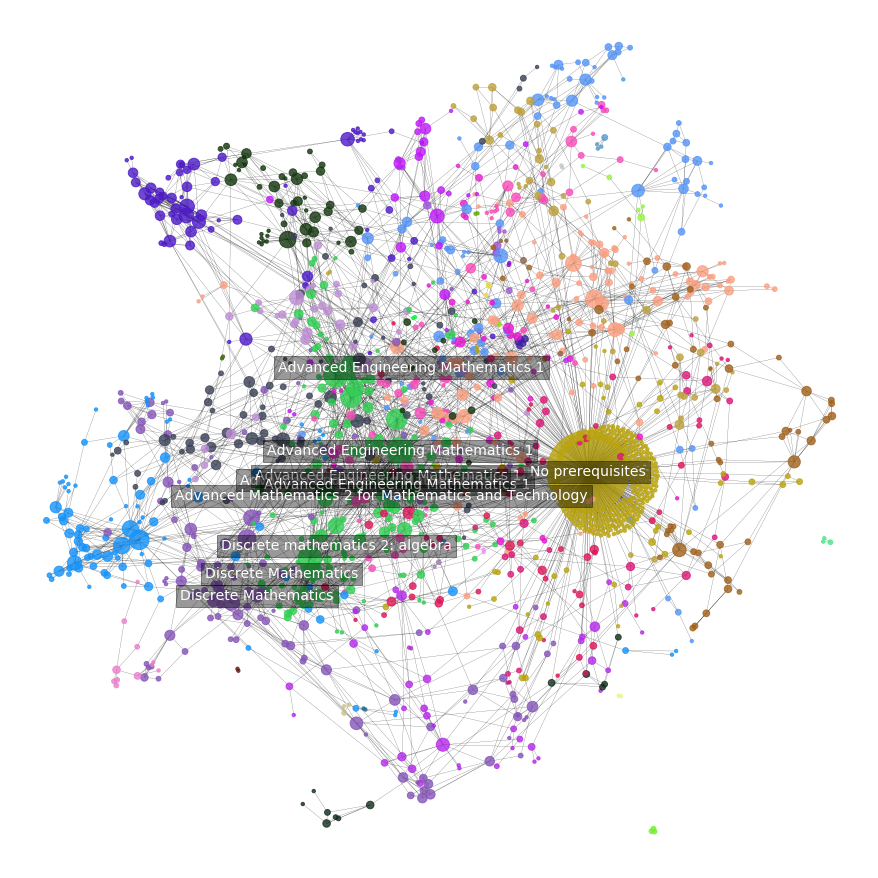

In [16]:
plt.figure(figsize=(12,12))
color_map = get_community_cmap(partition)
labels = {c:course_name(c) for c in DG.nodes if c in list(measure)[:10]}
nx.draw(G, node_size = [x*20E3 for x in size], pos = positions,
        width=.2, node_color = color_map, alpha = .8)
nx.draw_networkx_labels(DG, positions, labels, font_size = 14, font_color = 'w',
                        bbox=dict(facecolor='black', alpha=0.4) )
plt.show()

In [16]:
communities = {}
for p, c in partition.items():
    communities[c] = communities.get(c, [])
    communities[c].append(p)

In [18]:
[course_name(cnumber) for cnumber in communities[3]]

['Discrete Mathematics',
 'Discrete Mathematics',
 'Graph Theory',
 'Cryptology 1',
 'Computational Discrete Mathematics',
 'Cryptology 2',
 'Advanced topics in cryptology',
 'Graph Theory II',
 'Discrete mathematics',
 'Introductory Programming',
 'Introductory Programming',
 'Algorithms and Data Structures 1',
 'Algorithms and Data Structures',
 'Algorithms and Data Structures 2',
 'Introduction to Software Technology',
 'Software Technology Project',
 'Software Engineering 1',
 'No name found',
 'Computer Systems',
 'No name found',
 'No name found',
 'Digital Electronics 1',
 'Digital Electronics 2',
 'Functional Programming',
 'Computer Science Modelling',
 'Introduction to Coordination in Distributed Applications',
 'Computer Architecture and Engineering',
 'No name found',
 'Logical Systems and Logic Programming',
 'Concurrent Programming',
 'Operating Systems',
 'Agile Object-oriented Software Development',
 'Software Engineering 2',
 'Database Systems',
 'No name found',
 'Int

In [19]:
nx.algorithms.dag.is_directed_acyclic_graph(DG)

True

In [20]:
nx.algorithms.dag.dag_longest_path(DG)

['02315',
 '02314',
 '02313',
 '02312',
 '02324',
 '02267',
 '02809',
 '02266',
 '02808',
 '62573']

In [21]:
[course_name(cnum) for cnum in nx.algorithms.dag.dag_longest_path(DG)]

['Version control and test methods',
 'Introductory Programming',
 'Development Methods for IT Systems',
 'Introductory Programming',
 'Advanced Programming',
 'Software Development of Web Services',
 'UX Design Prototyping',
 'User Experience Engineering',
 'Personal Data Interaction for Mobile and Wearables',
 'Programming intelligent vehicles and Mobile Applications']

In [40]:
list(map(lambda x: "{} : {}".format(x, course_name(x)), nx.algorithms.dag.lexicographical_topological_sort(DG)))[::-1]

['88716 : Coatings Science and Technology',
 '88715 : Bioerefinery',
 '88713 : SDC Green Challenge',
 '88711 : Industrial BioReaction Engineering',
 '88710 : Combustion and High Temperature Processes',
 '88709 : Fluidization and Multiphase Flow',
 '88708 : Green Chemical Engineering',
 '88706 : Technology Economics Mangement and Organization (TEMO)',
 '88705 : Process Design - Principles & Methods',
 '88704 : Progress in Research',
 '88703 : Laboratory Experiments',
 '28831 : Computational Fluid Dynamics in Chemical Engineering',
 '88701 : Transport Processes',
 '88700 : Industrial Reaction Engineering',
 '62999 : Innovation Pilot',
 '62990 : Innovation Pilot (summer edition)',
 '62908 : Technology in interaction with humans',
 '62573 : Programming intelligent vehicles and Mobile Applications',
 '62148 : Building robots and devices for industrial automation',
 '62606 : Applied discrete control of mechanical, fluid and thermal plants',
 '62904 : Applied Control Engineering',
 '62800 : I